In [19]:
import pandas as pd
import numpy as np
import h5py
import os
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch import nn, optim
from collections import OrderedDict

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [20]:
ancho = 160
alto = 129
canales = 3
pixeles = ancho*alto*canales
cantidadClases = 5
clases = ['Banano', 'Granada', 'Kiwi', 'Mango', 'Pitaya']
batchSize = 64

In [21]:
def view_classify(img, ps):
  ps = ps.data.numpy().squeeze()
  fig, (ax1, ax2) = plt.subplots(figsize=(16,13), ncols=2)
  ax1.imshow(img.numpy().transpose((1, 2, 0)))
  ax1.axis('off')
  ax2.barh(np.arange(cantidadClases), ps)
  ax2.set_aspect(0.1)
  ax2.set_yticks(np.arange(cantidadClases))
  ax2.set_yticklabels(clases, size='medium');
  ax2.set_title('Probabilidad de las Clases')
  ax2.set_xlim(0, 1.1)

  plt.tight_layout()

In [22]:
transform = transforms.Compose([transforms.Resize((ancho, alto)),transforms.ToTensor(),])
current_dir = os.getcwd()
dataset_path = os.path.join(current_dir, 'dataset', 'Frutas', 'Train')
trainset = ImageFolder(root=dataset_path, transform=transform)
trainloader = DataLoader(trainset, batch_size=batchSize, shuffle=True)

testset_path = os.path.join(current_dir, 'dataset', 'Frutas', 'Test')
testset = ImageFolder(root=testset_path, transform=transform)
testloader = DataLoader(testset, batch_size=batchSize, shuffle=True)

In [23]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(pixeles, 20640)
    self.fc2 = nn.Linear(20640, 6880)
    self.fc3 = nn.Linear(6880, 2293)
    self.fc4 = nn.Linear(2293, 764)
    self.fc5 = nn.Linear(764, 254)
    self.fc6 = nn.Linear(254, 84)
    self.fc7 = nn.Linear(84, cantidadClases)
      
  def forward(self, x):
    
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    x = F.relu(self.fc6(x))
    x = F.log_softmax(self.fc7(x), dim=1)
    
    return x

In [24]:
model = Network()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)
image, label = next(iter(trainloader))

In [25]:
epochs = 5
for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:
    images = images.view(images.shape[0], -1)
    log_ps = model(images)
    loss = criterion(log_ps, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.6104900099463382
Training loss: 1.6089886810819982
Training loss: 1.6078150464316545
Training loss: 1.606692391937062
Training loss: 1.6054688772912753


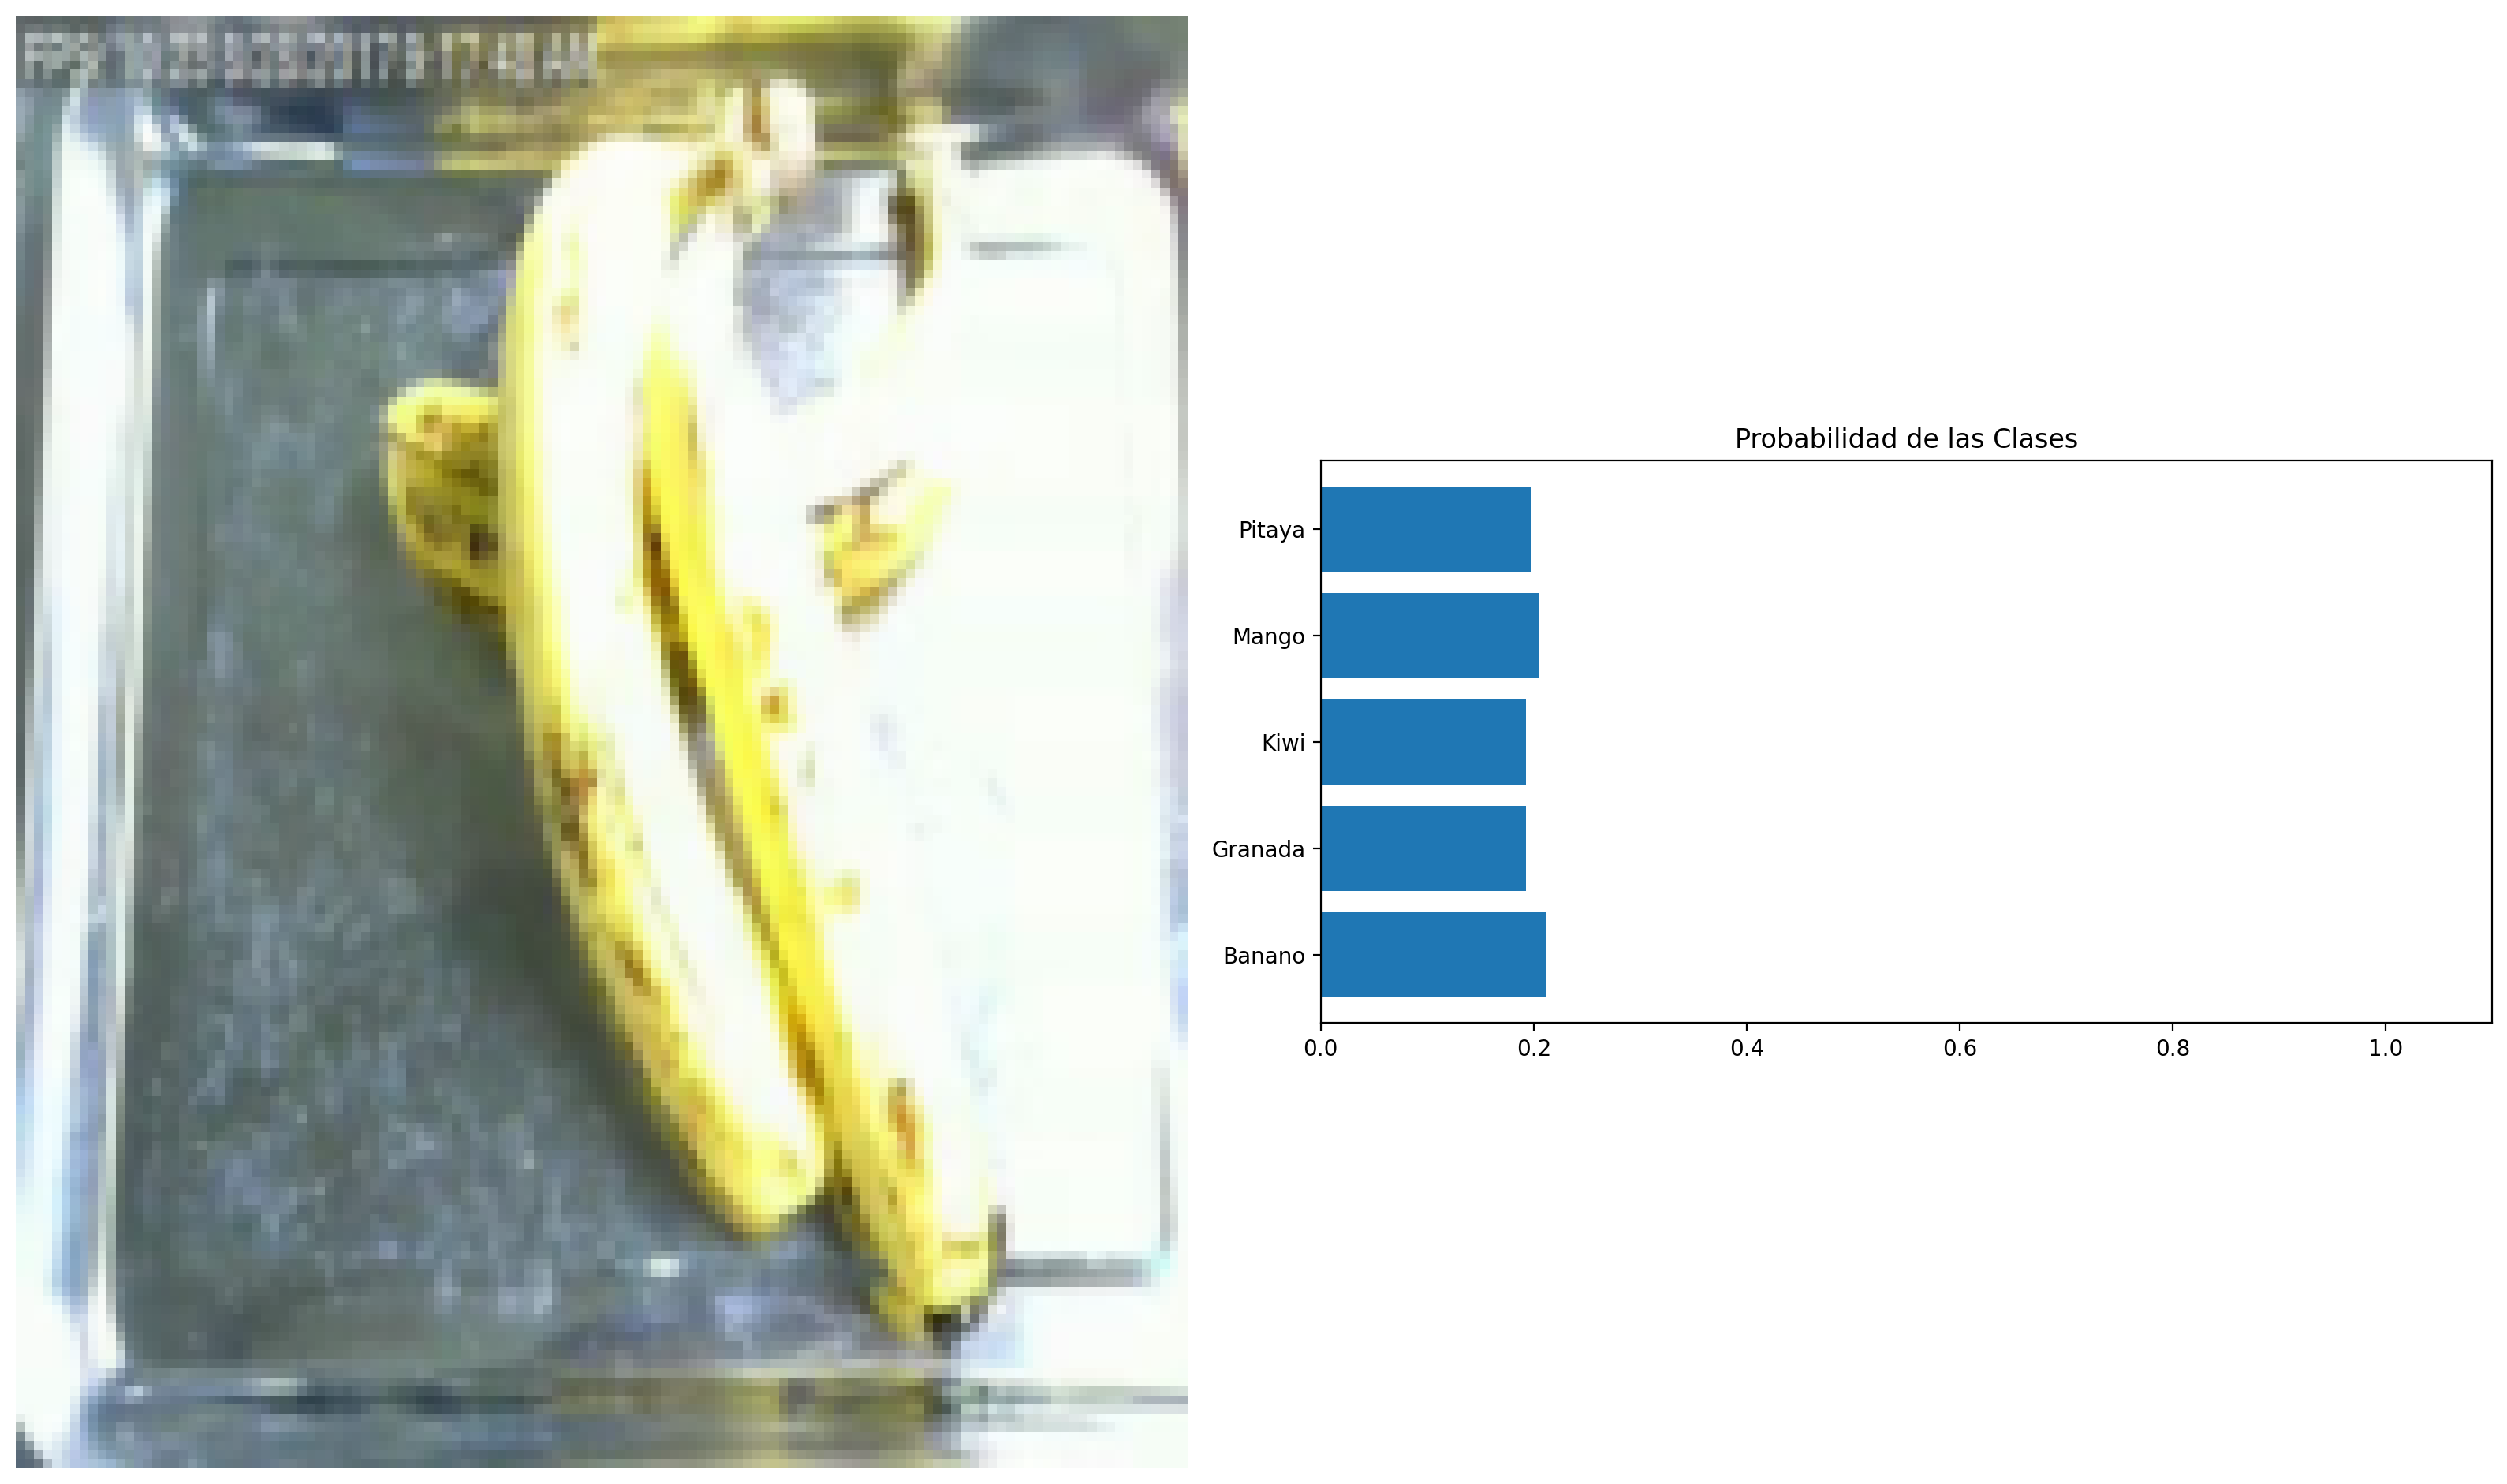

In [26]:
dataiter = iter(testloader)
images, labels = next(iter(testloader))
img = images[1].view(1, pixeles)

# TODO: Calculate the class probabilities (softmax) for img
ps = torch.exp(model(img))

# Plot the image and probabilities
view_classify(img.view(canales, ancho, alto), ps)